# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 24.11.2021

Мягкий дедлайн: 23:59MSK 07.12.2021


Жесткий дедлайн: 23:59MSK 10.12.2021

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from sklearn.datasets import load_boston
boston = load_boston()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
X = boston["data"]
y = boston["target"]

In [ ]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [ ]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

35.301623800668494

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor

In [ ]:
def create_boostrap(n_samples):
    trn_idx = np.random.choice(range(n_samples), n_samples)
    test_idx = list(set(range(n_samples)) - set(trn_idx))
    return trn_idx, test_idx

In [ ]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    error = 0
    # предсказания алгоритмов
    test_preds = np.zeros((num_runs, len(y)))
    # сколько раз объект вошел в out-of-bag
    test_count = np.zeros(len(y))
    for iter in range(num_runs):
        trn_idx, test_idx = create_boostrap(len(y))
        if len(test_idx) == 0:
            continue
        X_train = X[trn_idx]
        y_train = y[trn_idx]
        X_test = X[test_idx]
        y_test = y[test_idx]
        regressor.fit(X_train, y_train)

        pred = regressor.predict(X_test)
        error += np.mean((y_test - pred)**2)

        test_preds[iter, test_idx] = pred
        test_count[test_idx] += 1
    # сумма квадратов предсказаний для вычисления выборочной дисперсии
    squared_test_preds = (test_preds**2).sum(axis=0)
    # сумма предсказаний для вычисления выборочного среднего
    test_preds = test_preds.sum(axis=0)
    # отбрасываем элементы ни разу не встретившиеся в out-of-bag
    test_preds = test_preds[test_preds != 0]
    squared_test_preds = squared_test_preds[test_count != 0]
    y = y[test_count != 0]
    test_count = test_count[test_count != 0]

    # усредняем предсказания модели
    mean_pred = test_preds / test_count
    # разброс
    variance = np.mean(squared_test_preds / test_count - mean_pred**2)
    # смещение
    bias = np.mean((mean_pred - y)**2)
    return bias, variance, error / num_runs

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [ ]:
bias, variance, error = compute_biase_variance(LinearRegression(), X, y)
print("Linear Regression:")
print(f"bias: {bias:.5f}")
print(f"variance: {variance:.5f}")
print(f"error: {error:.5f}")

Linear Regression:
bias: 23.73373
variance: 0.92203
error: 24.66914


In [ ]:
bias, variance, error = compute_biase_variance(DecisionTreeRegressor(), X, y)
print("DecisionTreeRegressor:")
print(f"bias: {bias:.5f}")
print(f"variance: {variance:.5f}")
print(f"error: {error:.5f}")

DecisionTreeRegressor:
bias: 10.13704
variance: 12.99900
error: 23.17008


In [ ]:
bias, variance, error = compute_biase_variance(RandomForestRegressor(), X, y, 250)
print("RandomForestRegressor:")
print(f"bias: {bias:.5f}")
print(f"variance: {variance:.5f}")
print(f"error: {error:.5f}")

RandomForestRegressor:
bias: 10.96803
variance: 2.23638
error: 13.14480


__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__ Смещение показывает, насколько хорошо с помощью данных метода обучения и семейства алгоритмов можно приблизить оптимальный алгоритм. Как правило, смещение маленькое у сложных семейств (например, у деревьев) и большое у простых семейств (например, линейных классификаторов).

Дисперсия показывает, насколько сильно может изменяться ответ обученного алгоритма в зависимости от выборки --- иными словами, она характеризует чувствительность метода обучения к изменениям в выборке. Как правило, простые семейства имеют маленькую дисперсию, а сложные семейства --- большую дисперсию.



*   Линейная модель не может уловить сложные закономерности в данных, поэтому у нее высокое смещение, однако в целом модели довольно похожи, поэтому низкий разброс
*   Решающие деревья склонны к переобучению, поэтому у них высокий разброс, смещение в 2 раза ниже, чем у линейной регрессии, однако за счет большой чувствительности к данным, ошибка практически такая же
*   Метод обучения случайного леса устроен таким образом, что модель не видит все данные из обучающей выборки, поэтому ей сложнее будет переобучиться. Поэтому при +- таком же смещении у слачайного леса гораздо ниже разброс по сравнению с деревьями



__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__  Eсли базовые модели не коррелируют, то дисперсия композиции в N раз (N - число моделей в композиции) меньше дисперсии отдельных алгоритмов. Если модели коррелируют, то уменьшение дисперсии будет меньшим
*   Линейная регрессия обладает низким разбросом, то есть слабо зависит от изменений в данных. Прогнозы моделей сильно коррелируют, поэтому бэггинг не приносит пользы
*   Деревья обладают высоким разбросом, то есть сильно зависят от изменений в выборке, поэтому бэггинг с деревьями работает лучше всего. За счет бэггинга удалось снизить разброс случайного леса в 4 раза
*   Случайный лес зависит от выборки, но не так сильно, как деревья. Поэтому бэггинг помогает, но не так сильно, как деревьям, разброс за счет бэггинга снизился в 2 раза

In [ ]:
bias, variance, error = compute_biase_variance(
    BaggingRegressor(LinearRegression()), X, y)
print("Linear Regression with bagging:")
print(f"bias: {bias:.5f}")
print(f"variance: {variance:.5f}")
print(f"error: {error:.5f}")

Linear Regression with bagging:
bias: 23.75936
variance: 1.03112
error: 24.70024


In [ ]:
bias, variance, error = compute_biase_variance(
    BaggingRegressor(DecisionTreeRegressor()), X, y)
print(f"DecisionTreeRegressor with bagging:")
print(f"bias: {bias:.5f}")
print(f"variance: {variance:.5f}")
print(f"error: {error:.5f}")

DecisionTreeRegressor with bagging:
bias: 10.57643
variance: 3.42444
error: 13.95761


In [ ]:
bias, variance, error = compute_biase_variance(
    BaggingRegressor(RandomForestRegressor()), X, y, 50)
print(f"RandomForestRegressor with bagging:")
print(f"bias: {bias:.5f}")
print(f"variance: {variance:.5f}")
print(f"error: {error:.5f}")

RandomForestRegressor with bagging:
bias: 11.62343
variance: 1.52214
error: 13.25164


### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте функцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [ ]:
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [ ]:
def plot_predictions(regressor,
                     X,
                     y,
                     num_runs=100,
                     num_test_objects=10,
                     title=""):
    """
    plot graphics described above
    """
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=num_test_objects, random_state=42)
    for iter in range(num_runs):
        trn_idx, val_idx = create_boostrap(len(y))
        X_train = X[trn_idx]
        y_train = y[trn_idx]
        X_va = X[val_idx]
        y_va = y[val_idx]
        regressor.fit(X_train, y_train)
        preds = regressor.predict(X_test)
        plt.scatter(range(1, num_test_objects + 1), preds, color='red')
    plt.scatter(range(1, num_test_objects + 1), y_test, color='black')
    plt.ylim(5, 45)
    plt.xticks(range(1, num_test_objects + 1))
    plt.xlabel('test index')
    plt.ylabel('model prediction')
    plt.title(title)

__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

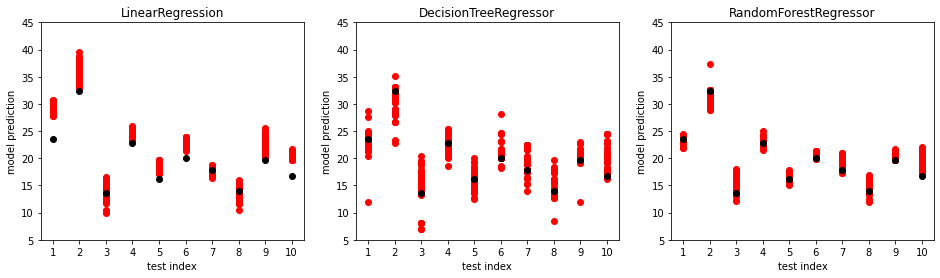

In [ ]:
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
plt.figure(figsize=(16, 4))
for i in range(len(models)):
    plt.subplot(1, 3, i + 1)
    plot_predictions(models[i], X, y, title=type(models[i]).__name__)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__ Графики подтвержают теорию
*  У линейной регрессии низкий разброс. Видно, что предсказания расположены близко друг к другу, также видно, что у модели высокое смещение, поскольку в половине случаев истинное значение не попало в интервал предсказаний
*  У деревьев высокий разброс, на графике видно, что некоторые предсказания сильно отличаются от остальных. Смещение ниже, чем у линейной регрессии, предсказания в среднем расположены ближе к истинному значению
*  В целом предсказания случайного леса расположены не так скученно, как у линейной регрессии, поэтому разброс выше. Смещение довольно низкое, так как предсказания расположены близко к истинному значению

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [ ]:
import seaborn as sns

In [ ]:
biases_depth, variances_depth = [], []
depths = range(1, 11)
for max_depth in depths:
    bias, variance, _ = compute_biase_variance(
        DecisionTreeRegressor(max_depth=max_depth), X, y)
    biases_depth.append(bias)
    variances_depth.append(variance)

In [ ]:
biases_features, variances_features = [], []
features = range(1, X.shape[1] + 1)
for max_features in features:
    bias, variance, _ = compute_biase_variance(
        DecisionTreeRegressor(max_features=max_features), X, y)
    biases_features.append(bias)
    variances_features.append(variance)

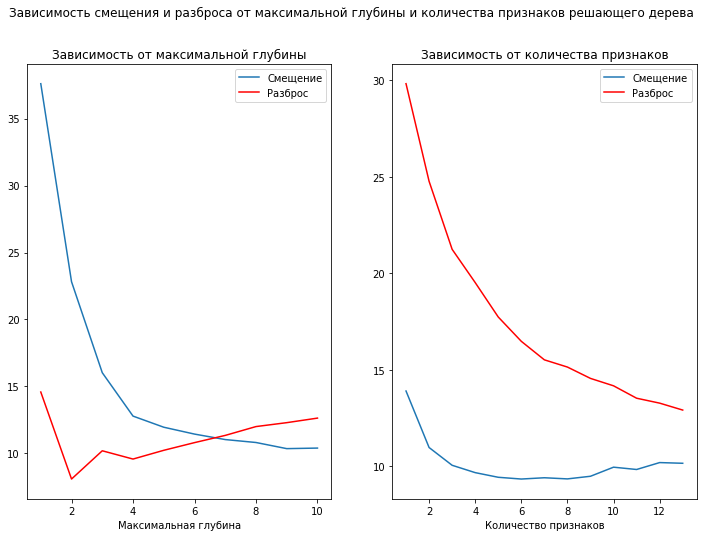

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.lineplot(x=depths, y=biases_depth, label='Смещение', ax=ax[0])
sns.lineplot(x=depths,
             y=variances_depth,
             label='Разброс',
             color='red',
             ax=ax[0])
sns.lineplot(x=features, y=biases_features, label='Смещение', ax=ax[1])
sns.lineplot(x=features,
             y=variances_features,
             label='Разброс',
             color='red',
             ax=ax[1])
ax[0].set_title('Зависимость от максимальной глубины')
ax[1].set_title('Зависимость от количества признаков')
ax[0].set_xlabel('Максимальная глубина')
ax[1].set_xlabel('Количество признаков')
plt.suptitle(
    'Зависимость смещения и разброса от максимальной глубины и количества признаков решающего дерева'
)
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
biases_rf, variances_rf = [], []
est = 2**np.arange(1, 10)
for n_estimators in est:
    bias, variance, _ = compute_biase_variance(
        RandomForestRegressor(n_estimators=n_estimators), X, y, 100)
    biases_rf.append(bias)
    variances_rf.append(variance)

In [ ]:
biases_gb, variances_gb = [], []
est = 2**np.arange(1, 10)
for n_estimators in est:
    bias, variance, _ = compute_biase_variance(
        GradientBoostingRegressor(n_estimators=n_estimators), X, y, 100)
    biases_gb.append(bias)
    variances_gb.append(variance)

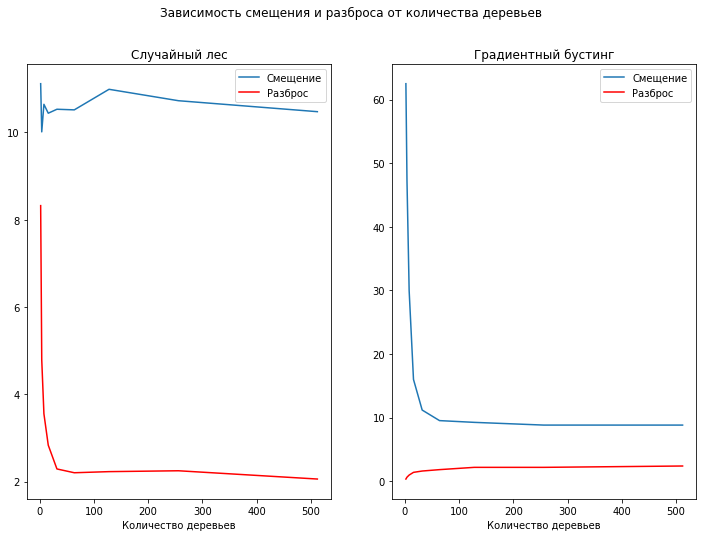

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))
sns.lineplot(x=est, y=biases_rf, label='Смещение', ax=ax[0])
sns.lineplot(x=est, y=variances_rf, label='Разброс', color='red', ax=ax[0])
sns.lineplot(x=est, y=biases_gb, label='Смещение', ax=ax[1])
sns.lineplot(x=est, y=variances_gb, label='Разброс', color='red', ax=ax[1])
ax[0].set_title('Случайный лес')
ax[1].set_title('Градиентный бустинг')
ax[0].set_xlabel('Количество деревьев')
ax[1].set_xlabel('Количество деревьев')
plt.suptitle('Зависимость смещения и разброса от количества деревьев')
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__
1.  **Зависимость смещения и разброса от максимальной глубины решающего дерева:** При увеличении глубины решающего дерево смещение снижается. Модель становится все более и более сложной, следовательно может улавливать сложные зависимости в данных. Однако, с увеличением глубины (>2) дерево все сильнее и сильнее подгоняется под обучающую выборку, то есть увеличивается разброс
2.  **Зависимость смещения и разброса количества признаков решающего дерева:**
При увеличении количества признаков уменьшается разброс случайного дерева. Модель может улавливать зависимости между разными признаками в обучающем наборе.
При количестве признаков = 1 мы можем наблюдать пример недообучения. При количестве признаков = 4 можно наблюдать минимальный разброс, затем он начинает увеличиваться, это говорит о том, что модель начинает переобучаться под обучающую выборку
3. **Зависимость смещения и разброса от количества деревьев в случайном лесе:** 
При изменении количества деревьев в решающем дереве смещение практически не меняется (Теоретически должно быть так: cмещение случайного леса равно смещению одной базовой модели). Так как прогнозы случайного дерева коррелируют не так сильно, как, например, линейной регрессии, видим, что с увеличением количества деревьев примерно до 250 разброс модели постепенно снижается, каждое дерево вносит свой вклад в прогноз, однако затем выходит на плато.
4. **Зависимость смещения и разброса от количества деревьев в градиентом бустинге**: Алгоритм градиентного бустинга устроен таким образом, что каждый следующий алгоритм $\beta_{n}$ строится так, чтобы композиция его и композиции $\alpha_{n-1}$ построенных алгоритмов максимально снижала ошибку. До какого-то момента происходит уменьшение смещения, то есть следующий алгоритм вносит свой вклад в уменьшение ошибки, но при этом разброс увеличивается,так как модель постепенно подгоняется под обучающую выборку. Затем наступает ситуация плато.

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.